In [7]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

instead do rds files of otu?

In [8]:
ps <- readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")

In [9]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]

In [10]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

In [11]:
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]

## is renaming the ASV to shorten the name from seq necessary?
dna df holds original dna seqneces as column names

In [12]:
#renaming the taxa to a short string while maintaining full dna seq in the background
dna <- Biostrings::DNAStringSet(taxa_names(ps_norm))
names(dna) <- taxa_names(ps_norm)
ps_norm <- merge_phyloseq(ps_norm, dna)
taxa_names(ps_norm) <- paste0("ASV", seq(ntaxa(ps_norm)))
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 107292 reference sequences ]

In [13]:
#remember to set.seed to make things reproducible
set.seed(99) 

In [14]:
theme_set(theme_bw())

### NMDS ordination removing order chloroplast with phyloseq
interesting SSIDs are not clustering at all

In [15]:
#making this plot wider
options(repr.plot.width=30, repr.plot.height=15)
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(20)
# Generate a random set of colors 
    mycolors <- sample(mycolors, 20)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2408917 
Run 1 stress 0.2335163 
... New best solution
... Procrustes: rmse 0.06806886  max resid 0.2249335 
Run 2 stress 0.2391261 
Run 3 stress 0.2232687 
... New best solution
... Procrustes: rmse 0.0712637  max resid 0.3596116 
Run 4 stress 0.242417 
Run 5 stress 0.2299085 
Run 6 stress 0.230043 
Run 7 stress 0.2456161 
Run 8 stress 0.2307807 
Run 9 stress 0.237353 
Run 10 stress 0.2272514 
Run 11 stress 0.2479143 
Run 12 stress 0.2519192 
Run 13 stress 0.233506 
Run 14 stress 0.2441292 
Run 15 stress 0.2296964 
Run 16 stress 0.2585559 
Run 17 stress 0.2267186 
Run 18 stress 0.2357675 
Run 19 stress 0.2542769 
Run 20 stress 0.2290367 
Run 21 stress 0.2379242 
Run 22 stress 0.2419371 
Run 23 stress 0.2544402 
Run 24 stress 0.2333617 
Run 25 stress 0.2307871 
Run 26 stress 0.2527283 
Run 27 stress 0.2297375 
Run 28 stress 0.2209114 
... New best solution
... Procrustes: rmse 0.01325953  max resid 0.1234061 
Ru

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


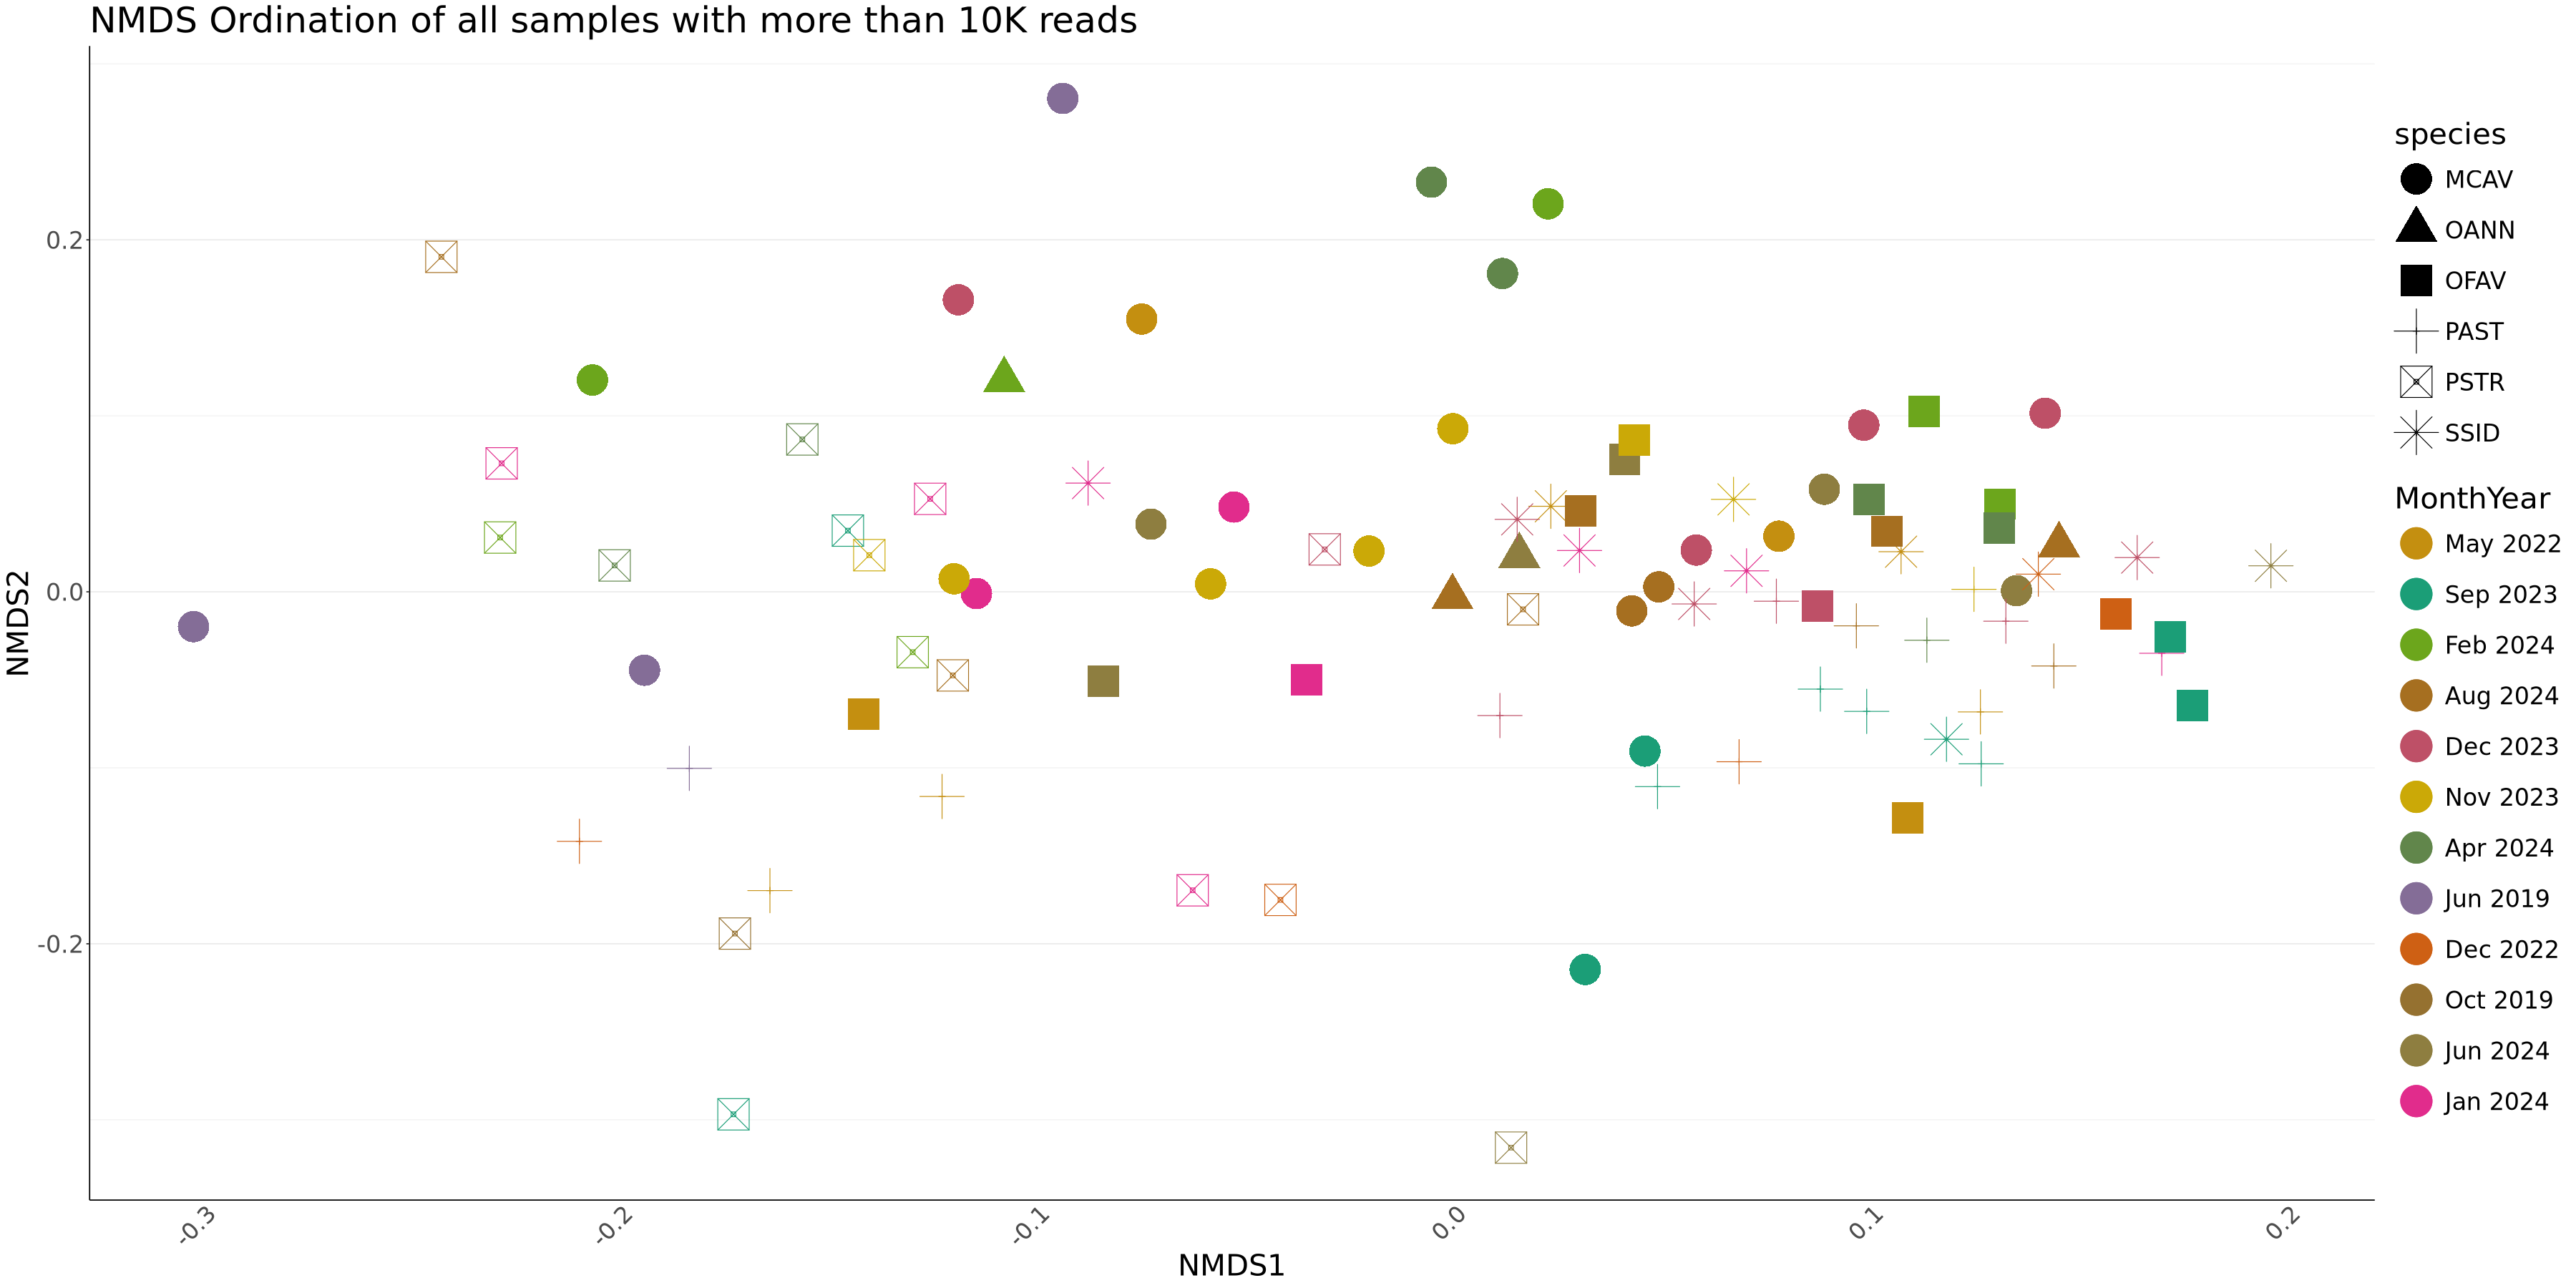

In [17]:
ps_norm.ord <- ordinate(ps_norm, "NMDS", "bray", trymax=1000)

ps_nmds <- plot_ordination(ps_norm, ps_norm.ord, type="samples", color="MonthYear", shape="species" )+ 
geom_point(size=12) + 
  labs(title = "NMDS Ordination of all samples with more than 10K reads",
       x = "NMDS1",
       y = "NMDS2") +
  scale_fill_manual(values = mycolors, drop = TRUE) +
  scale_color_manual(values = mycolors, drop = TRUE) +
  theme_bw() +
theme(
    legend.position = "right",
    legend.title = element_text(size = 25),
  legend.text = element_text(size = 20),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
    text = element_text(size = 25)) +

guides(color = guide_legend(override.aes = list(size = 12))) 

ps_nmds

In [18]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/94nmds.png", plot = ps_nmds, width = 30, height = 15, units = "in", dpi = 300)

# vegan NMDS ordination
- Stress values >0.2 are generally poor and potentially uninterpretable, whereas values <0.1 are good and <0.05 are excellent, leaving little danger of misinterpretation. Stress values between 0.1 and 0.2 are useable but some of the distances will be misleading. 

# vegan time!
- converting ps_norm to a usable state in vegan bc vegan can't read phyloseq objects, can only read separate df and matrices
- ALSO can't head() a phyloseq object 
- use metaMDS() in vegan to create a nmds plot that is automatically stable and not trapped in local optima
- metaMDS() in vegan automatically rotates the final result of the NMDS using PCA to make axis 1 correspond to the greatest variance among the NMDS sample points

In [20]:
# function to convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm) {
  sd_veg <- sample_data(ps_norm)
  return(as(sd_veg,"data.frame"))
}
# function to convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm) {
  otu_veg <- otu_table(ps_norm)
  if (taxa_are_rows(otu_veg)) {
    otu_veg <- t(otu_veg) #vegan functions assume samples are rows and taxa are columns, so if the taxa are currently rows, the code transposes the matrix with t(otu_norm)
  }
  return(as(otu_veg, "matrix"))
}

In [21]:
# Extract normalized OTU matrix and sample data
otu_norm <- psotu2veg(ps_norm)
sample_norm <- pssd2veg(ps_norm)

In [22]:
class(otu_norm)

[1] "matrix" "array"

In [23]:
head(sample_norm)

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,43,578,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,151,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,7,277,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,012024,T2,SSID,Jan 2024,38,434,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,012024,T3,PAST,Jan 2024,0,872,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,45,331,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


In [24]:
#cleaning up sample_norm to only be metadata
sample_norm <- sample_norm[, c("Health_Status", "colony", "Date_16S", "double_band", "date_sampled", "transect", "species", "MonthYear")]

In [25]:
head(otu_norm)
head(sample_norm)

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,⋯,ASV107283,ASV107284,ASV107285,ASV107286,ASV107287,ASV107288,ASV107289,ASV107290,ASV107291,ASV107292
012024_BEL_CBC_T1_557_SSID,361.95286,4865.3199,40000.00000,269.36027,0.0000,3535.354,521.8855,48223.9057,101.01010,2971.3805,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T1_563_PSTR,0.00000,3138.2492,789.75808,1143.07091,166.2649,28265.026,0.0000,190165.4335,0.00000,1018.3723,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T2_601_OFAV,36.53731,1445.8334,12229.55868,27737.03578,0.0000,34418.143,626.3538,214.0042,56194.37847,2834.2511,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T2_605_SSID,73.36460,837.9009,29175.94182,23.16777,0.0000,30204.977,287.6664,82486.9054,27.02906,992.3527,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_627_PAST,0.00000,658.8073,37.02014,66.48514,0.0000,1606.221,0.0000,17128.2347,18.88782,105.0163,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_631_MCAV,106.10480,780.4597,282.94613,14.14731,0.0000,414513.722,0.0000,11902.6005,25.93673,294.7356,⋯,0,0,0,0,0,0,0,0,0,0


,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,012024,T2,SSID,Jan 2024
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,012024,T3,PAST,Jan 2024
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024


I am happy I looked at sample_norm bc what is this, maybe I don't want to change the sequences to ASV1..?
also i might have made a mistake when I filtered for 10K reads bc it seems like I merged track_clean into samdf

In [26]:
# Should return TRUE
all(rownames(sample_norm) == rownames(otu_norm))

[1] TRUE

# NMDS Ordination with vegan

In [27]:
set.seed(12)

# using standard metaMDS (sqrt+wisconsin) because my data has not been transformed 
I want to balance influence between rare species and dominant species

use NMDS2 isntead of NMDS1 <- metaMDS(dist, k = 2, trymax = 100, trace = F)
because lower stress level and results Repeated 5 times in 20 tries

In [28]:
#after plotting # dimensions vs stress I see that my values are all <0.2 so is it okay (not the best for perfect interp)
#using k=2 bc I want to make a 2-D plot

# If you don`t provide a dissimilarity matrix, metaMDS automatically applies Bray-Curtis. So in our case, the results would have to be the same
NMDS2 <- metaMDS(otu_norm, k = 2, trymax = 100, trace = F)
NMDS2


Call:
metaMDS(comm = otu_norm, k = 2, trymax = 100, trace = F) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(otu_norm)) 
Distance: bray 

Dimensions: 2 
Stress:     0.2238834 
Stress type 1, weak ties
Best solution was repeated 1 time in 34 tries
The best solution was from try 17 (random start)
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sqrt(otu_norm))’ 


# now use sample data to see what is driving the observed differences

In [29]:
# Check matching sample order
all(rownames(NMDS2$points) == rownames(sample_norm))  # Should be TRUE

[1] TRUE

In [ ]:
#change options of this plot


***FACTORS:

Centroids:
                               NMDS1   NMDS2
Health_StatusDiseased_Tissue  0.0811 -0.0558
Health_StatusHealthy         -0.0009  0.0006
colony1_12                    0.1863 -0.0091
colony1_13                   -0.0954  0.0692
colony1_2                    -0.1088  0.0550
colony1_21                    0.0280  0.0694
colony1_24                    0.0003 -0.1603
colony1_25                    0.0326 -0.0589
colony1_3                    -0.0811 -0.0309
colony2_55                    0.1436  0.0273
colony2_57                   -0.1270  0.0368
colony2_60                   -0.0750 -0.0426
colony2_63                   -0.1456  0.0922
colony2_68                   -0.1237  0.0363
colony2_69                    0.0233 -0.0684
colony2_72                   -0.1352  0.0956
colony2_73                   -0.1365 -0.0130
colony2_76                   -0.1054 -0.0195
colony2_79                   -0.0666  0.0477
colony2_99                   -0.0785 -0.0329
colony3_10                    

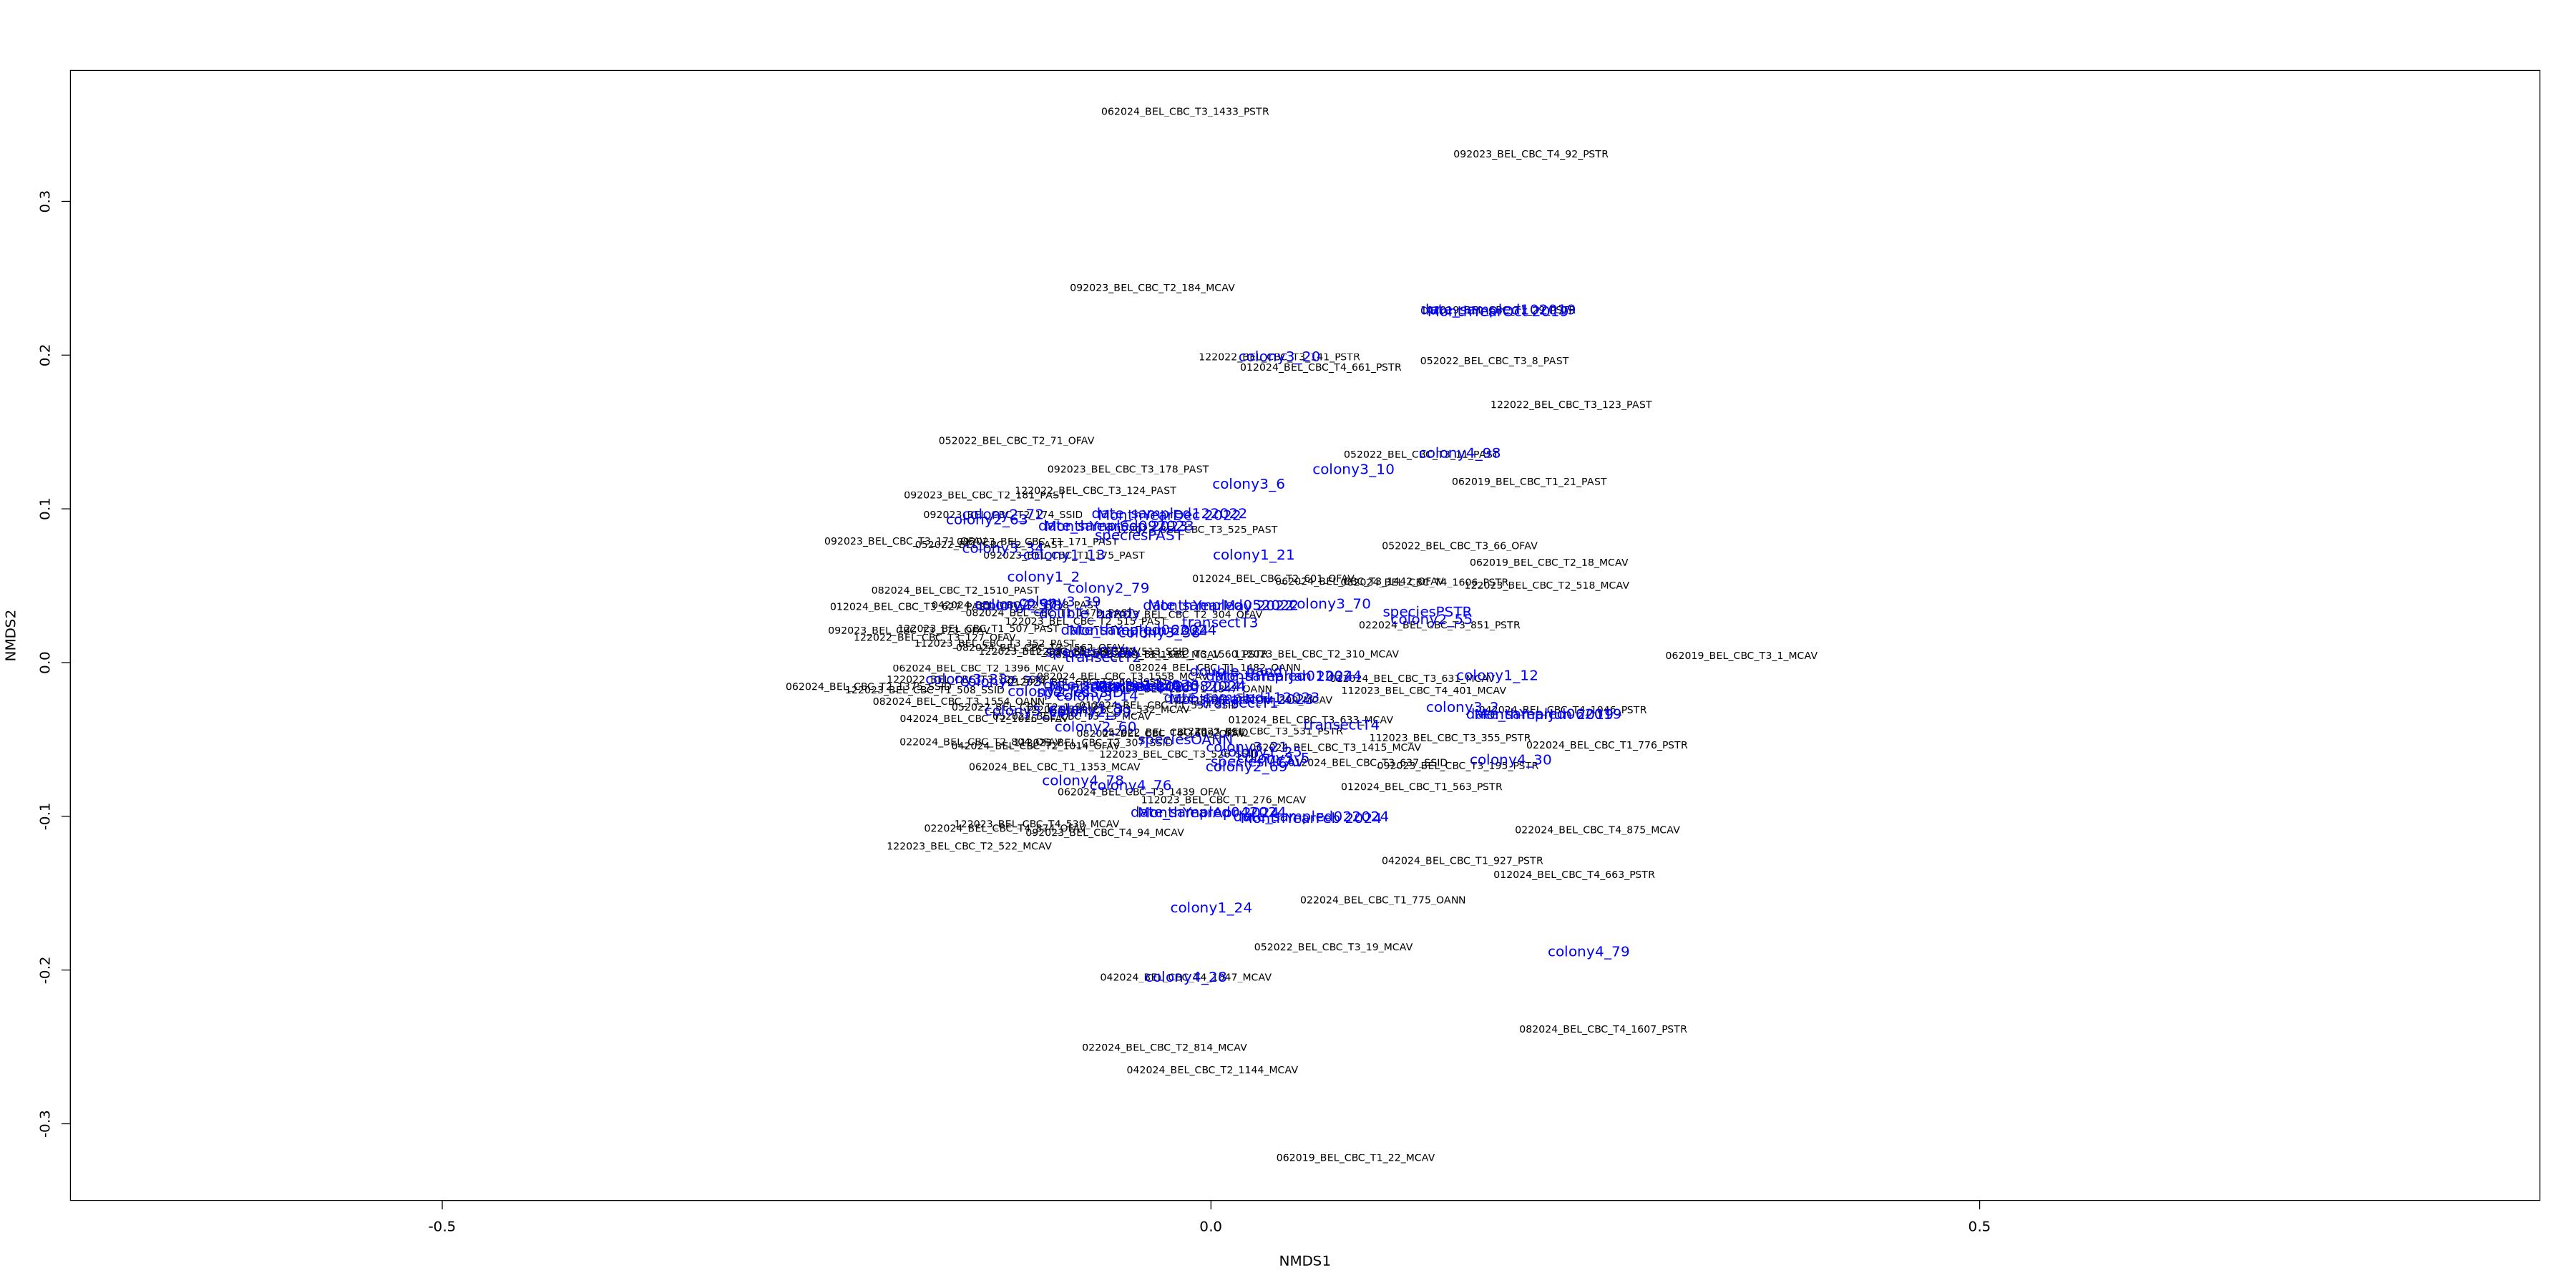

In [30]:
#vector fitting using a regression
# The function envfit will add the environmental variables as vectors to the ordination plot
ef <- envfit(NMDS2, sample_norm, permu = 999)
ef

# The two last columns are of interest: the squared correlation coefficient and the associated p-value
# Plot the vectors of the significant correlations and interpret the plot
plot(NMDS2, type = "t", display = "sites")
plot(ef, p.max = 0.05)

### stats

In [31]:
# variables with no interaction
adonis2(vegdist(otu_norm, method = "bray") ~ species + date_sampled, data = sample_norm)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
species,5,4.705190,0.1878437,2.453091,0.001
date_sampled,10,4.615103,0.1842472,1.203062,0.002
Residual,41,15.728138,0.6279091,NA,NA
Total,56,25.048431,1.0000000,NA,NA


## notes on after clustering after cleaning cutadapt and removing chloroplast asv
date sampled, and species are most significant variables


## old stuff using anchoring in cutadapt and not using discard-untrimmed

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1318083 
Run 1 stress 0.120452 
... New best solution
... Procrustes: rmse 0.05695577  max resid 0.1588814 
Run 2 stress 0.1182456 
... New best solution
... Procrustes: rmse 0.01907139  max resid 0.09736838 
Run 3 stress 0.1134218 
... New best solution
... Procrustes: rmse 0.03473449  max resid 0.1376813 
Run 4 stress 0.1275501 
Run 5 stress 0.1120503 
... New best solution
... Procrustes: rmse 0.0164612  max resid 0.1118247 
Run 6 stress 0.1340251 
Run 7 stress 0.1154324 
Run 8 stress 0.1204859 
Run 9 stress 0.1183149 
Run 10 stress 0.120368 
Run 11 stress 0.1292357 
Run 12 stress 0.1164942 
Run 13 stress 0.1180583 
Run 14 stress 0.1189852 
Run 15 stress 0.1373618 
Run 16 stress 0.1182456 
Run 17 stress 0.1328633 
Run 18 stress 0.1305816 
Run 19 stress 0.1154324 
Run 20 stress 0.1124543 
... Procrustes: rmse 0.01170506  max resid 0.08238493 
Run 21 stress 0.1120503 
... Procrustes: rmse 8.201617e-06  max resi

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


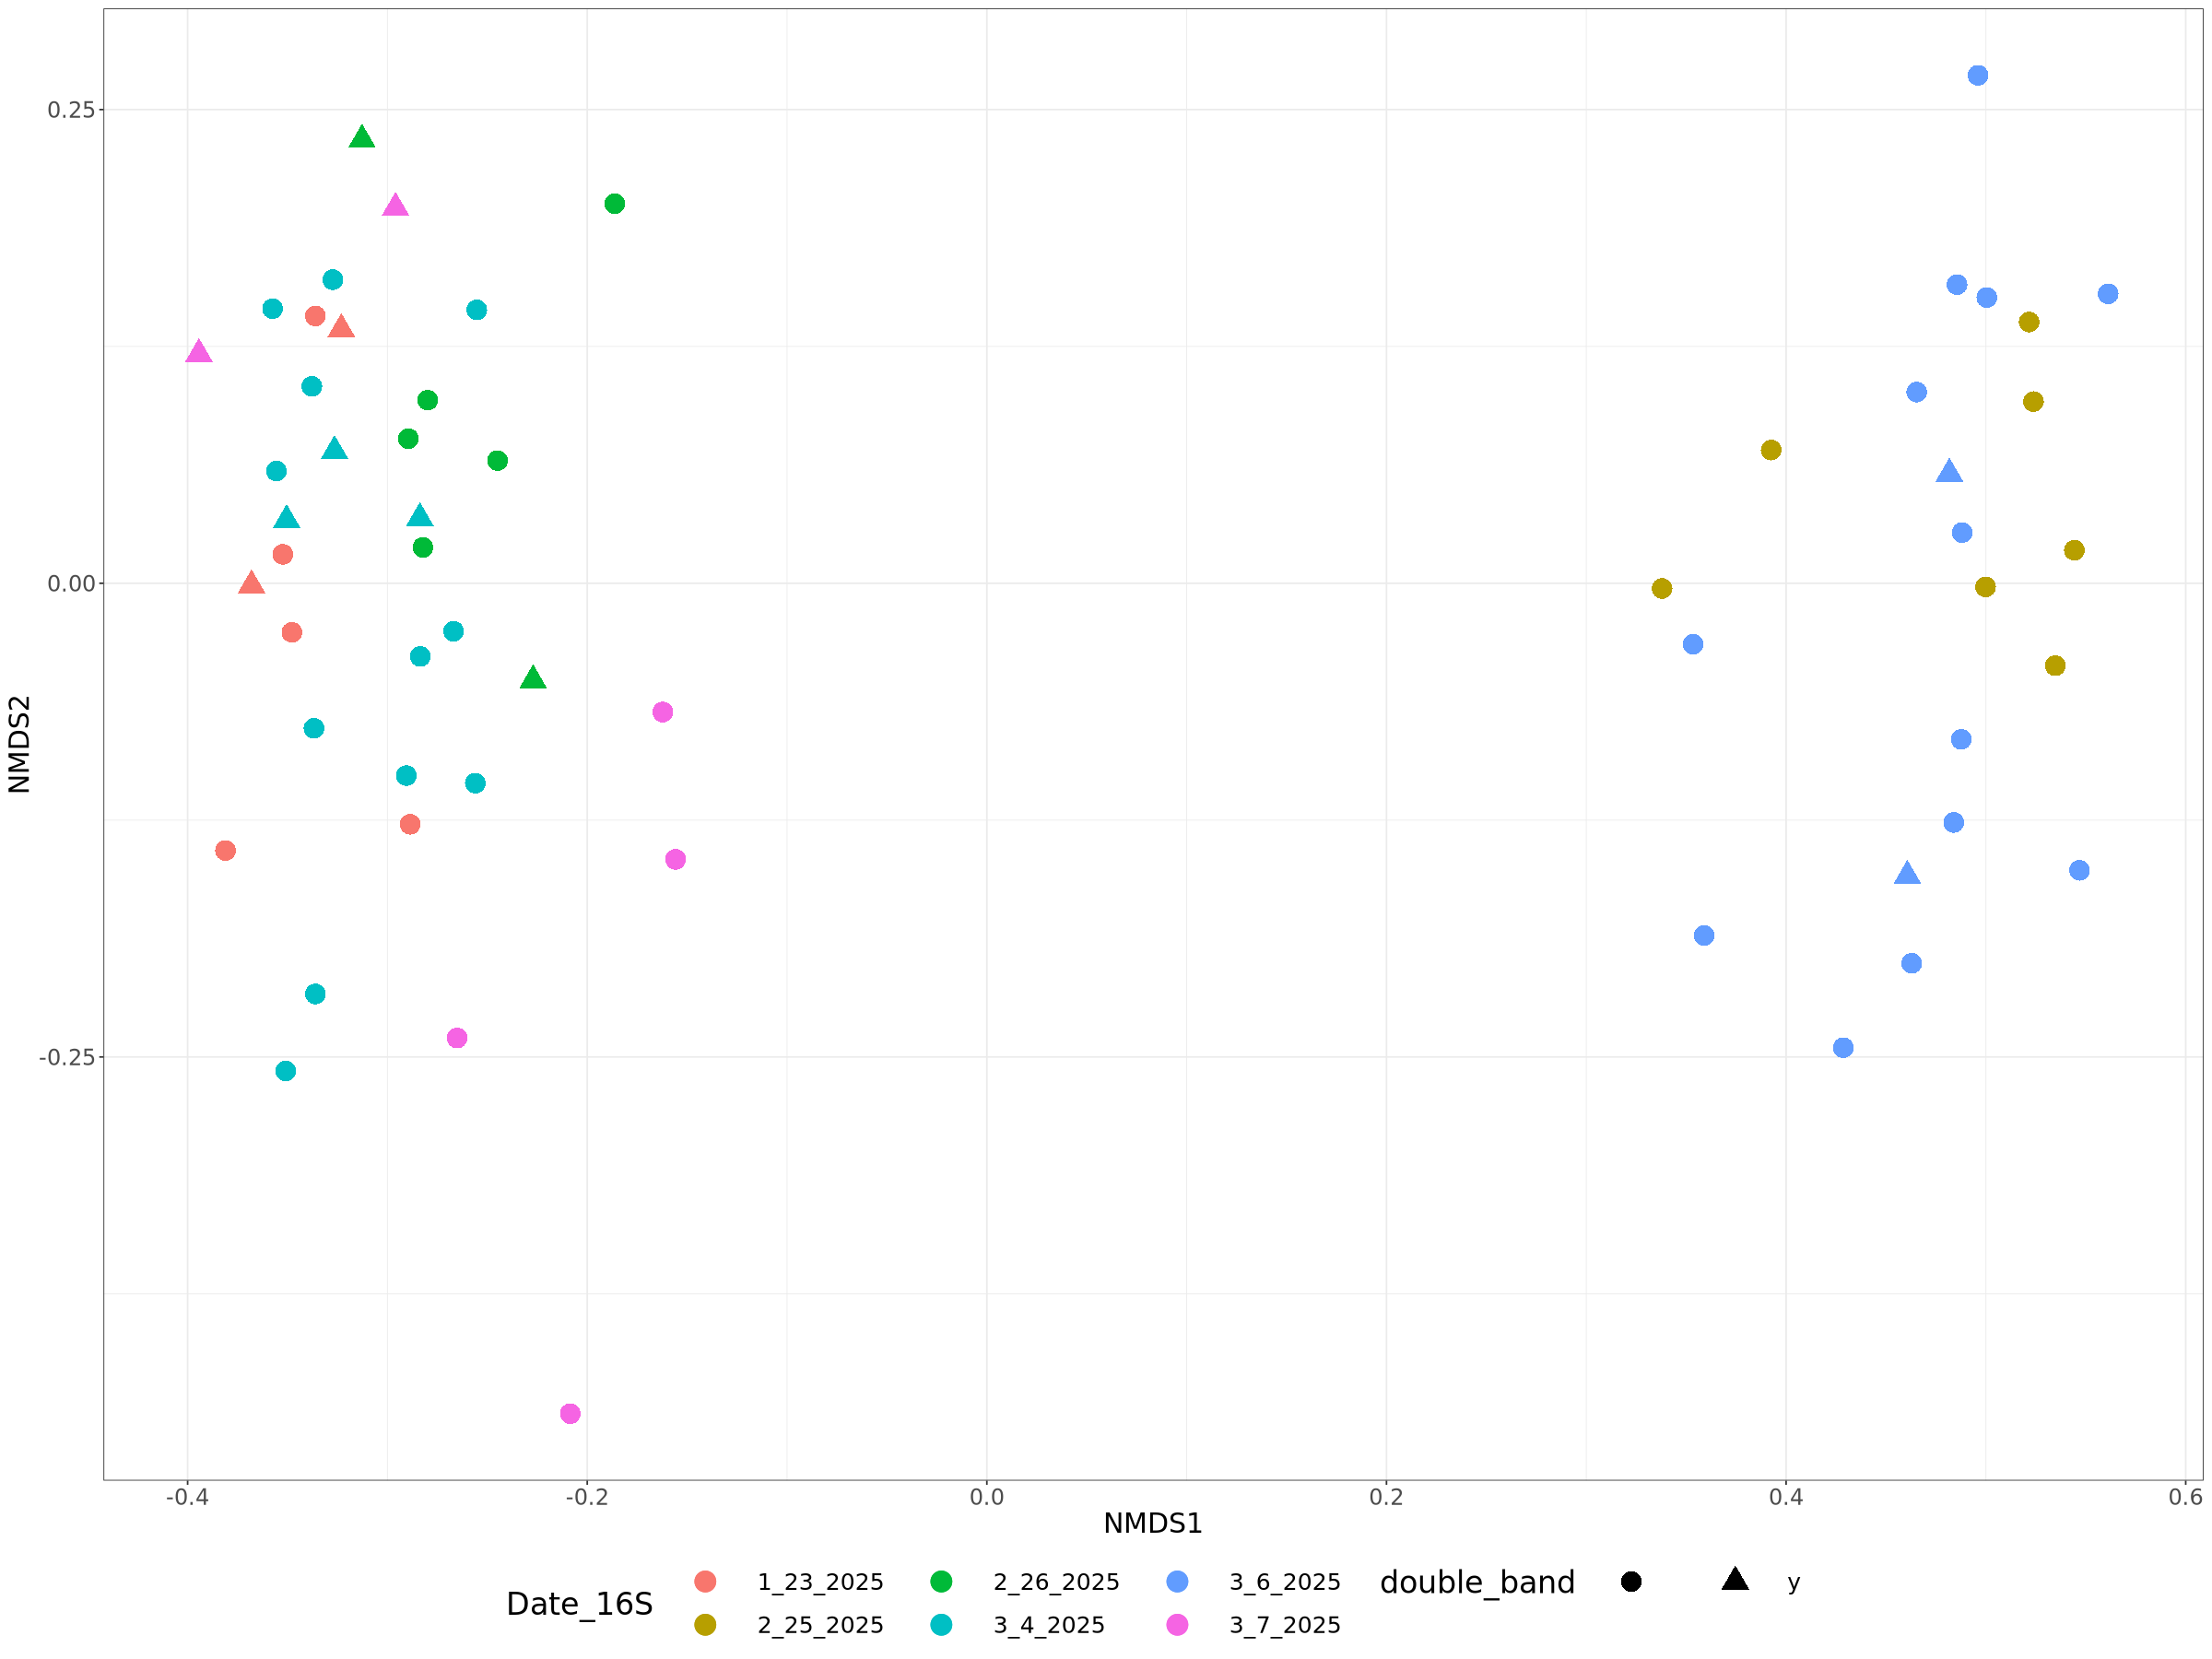

In [16]:
ps_norm.ord <- ordinate(ps_norm_nochlo, "NMDS", "bray", trymax=1000)
ps_nmds <- plot_ordination(ps_norm_nochlo, ps_norm.ord, type="samples", color="Date_16S", shape="double_band" )+ 
geom_point(size=6) + theme(
    legend.position = "bottom",  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 18),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 6))) 

ps_nmds

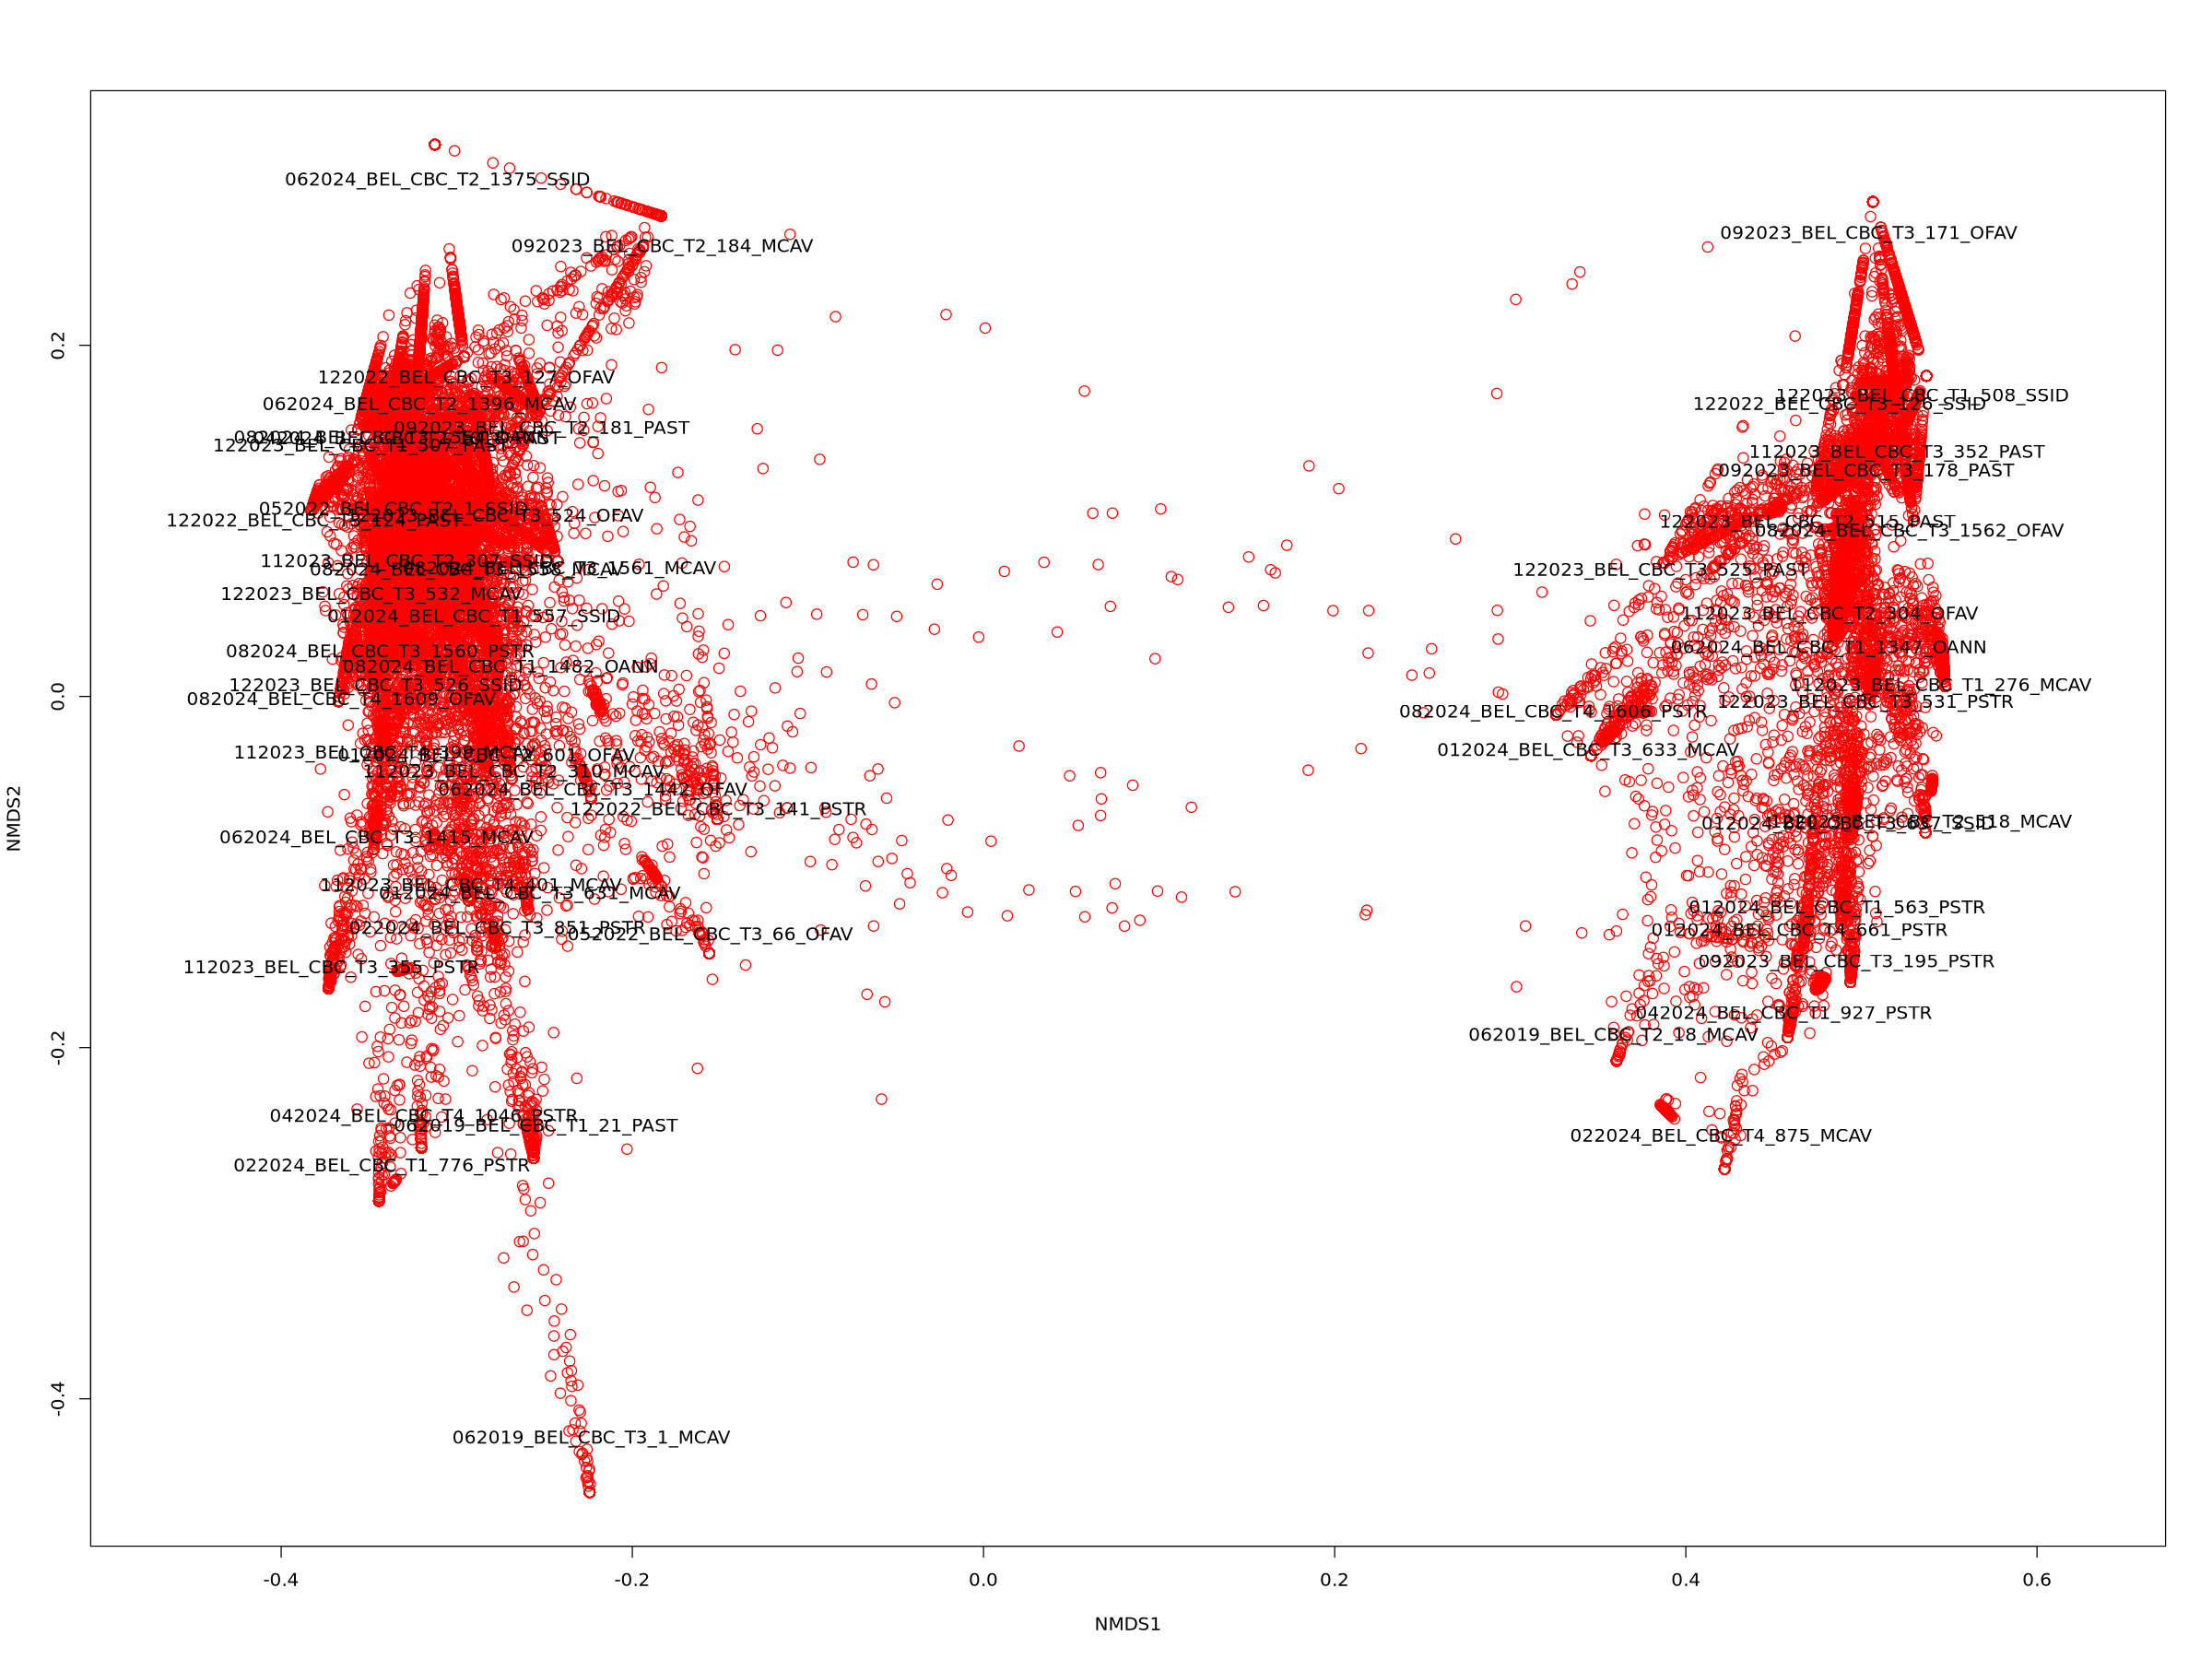

In [17]:
plot(NMDS2, display = "species", type = "n")
points(NMDS2, display = "species", col = "red", cex = 1.25)
text(NMDS2, display ="sites")

In [27]:
#variables nested within eachother
#this one is species within transect with date as another variable
adonis2(vegdist(otu_norm, method = "bray") ~ Date_16S/species + date, data = sample_norm)


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Date_16S,5,4.763527,0.1827989,3.191087,0.001
date,10,4.235814,0.1625481,1.418786,0.001
Date_16S:species,23,11.685559,0.4484298,1.701773,0.001
Residual,18,5.373937,0.2062232,NA,NA
Total,56,26.058837,1.0000000,NA,NA


In [ ]:
#variables with 2-way and 3- way interaction
adonis2(vegdist(otu_norm, method = "bray") ~ species * transect * Date_16S, data = sample_norm)

# not using Principle Component Analysis plots because it does not visualize my data well
- to help me visualize NMDS plots in a different way, uncover what is clustering on the X-axis

- plots PCA 1 and 2 along axes that are the variable, therefore is PCA1 is closer to species it is more impacted by species differences
- the first axis has the highest eigenvalue and thus explains the most variance

- The eigenvalues represent the variance extracted by each PC, and are often expressed as a percentage of the sum of all eigenvalues (i.e. total variance). 

In [ ]:
set.seed(222)

In [ ]:
ps_pca <- pca(decostand(ps_norm, method = "Bray"), scale = False) 
ps_pca

In [31]:
#build PCA ord
PCA <- rda(otu_norm, scale = FALSE)

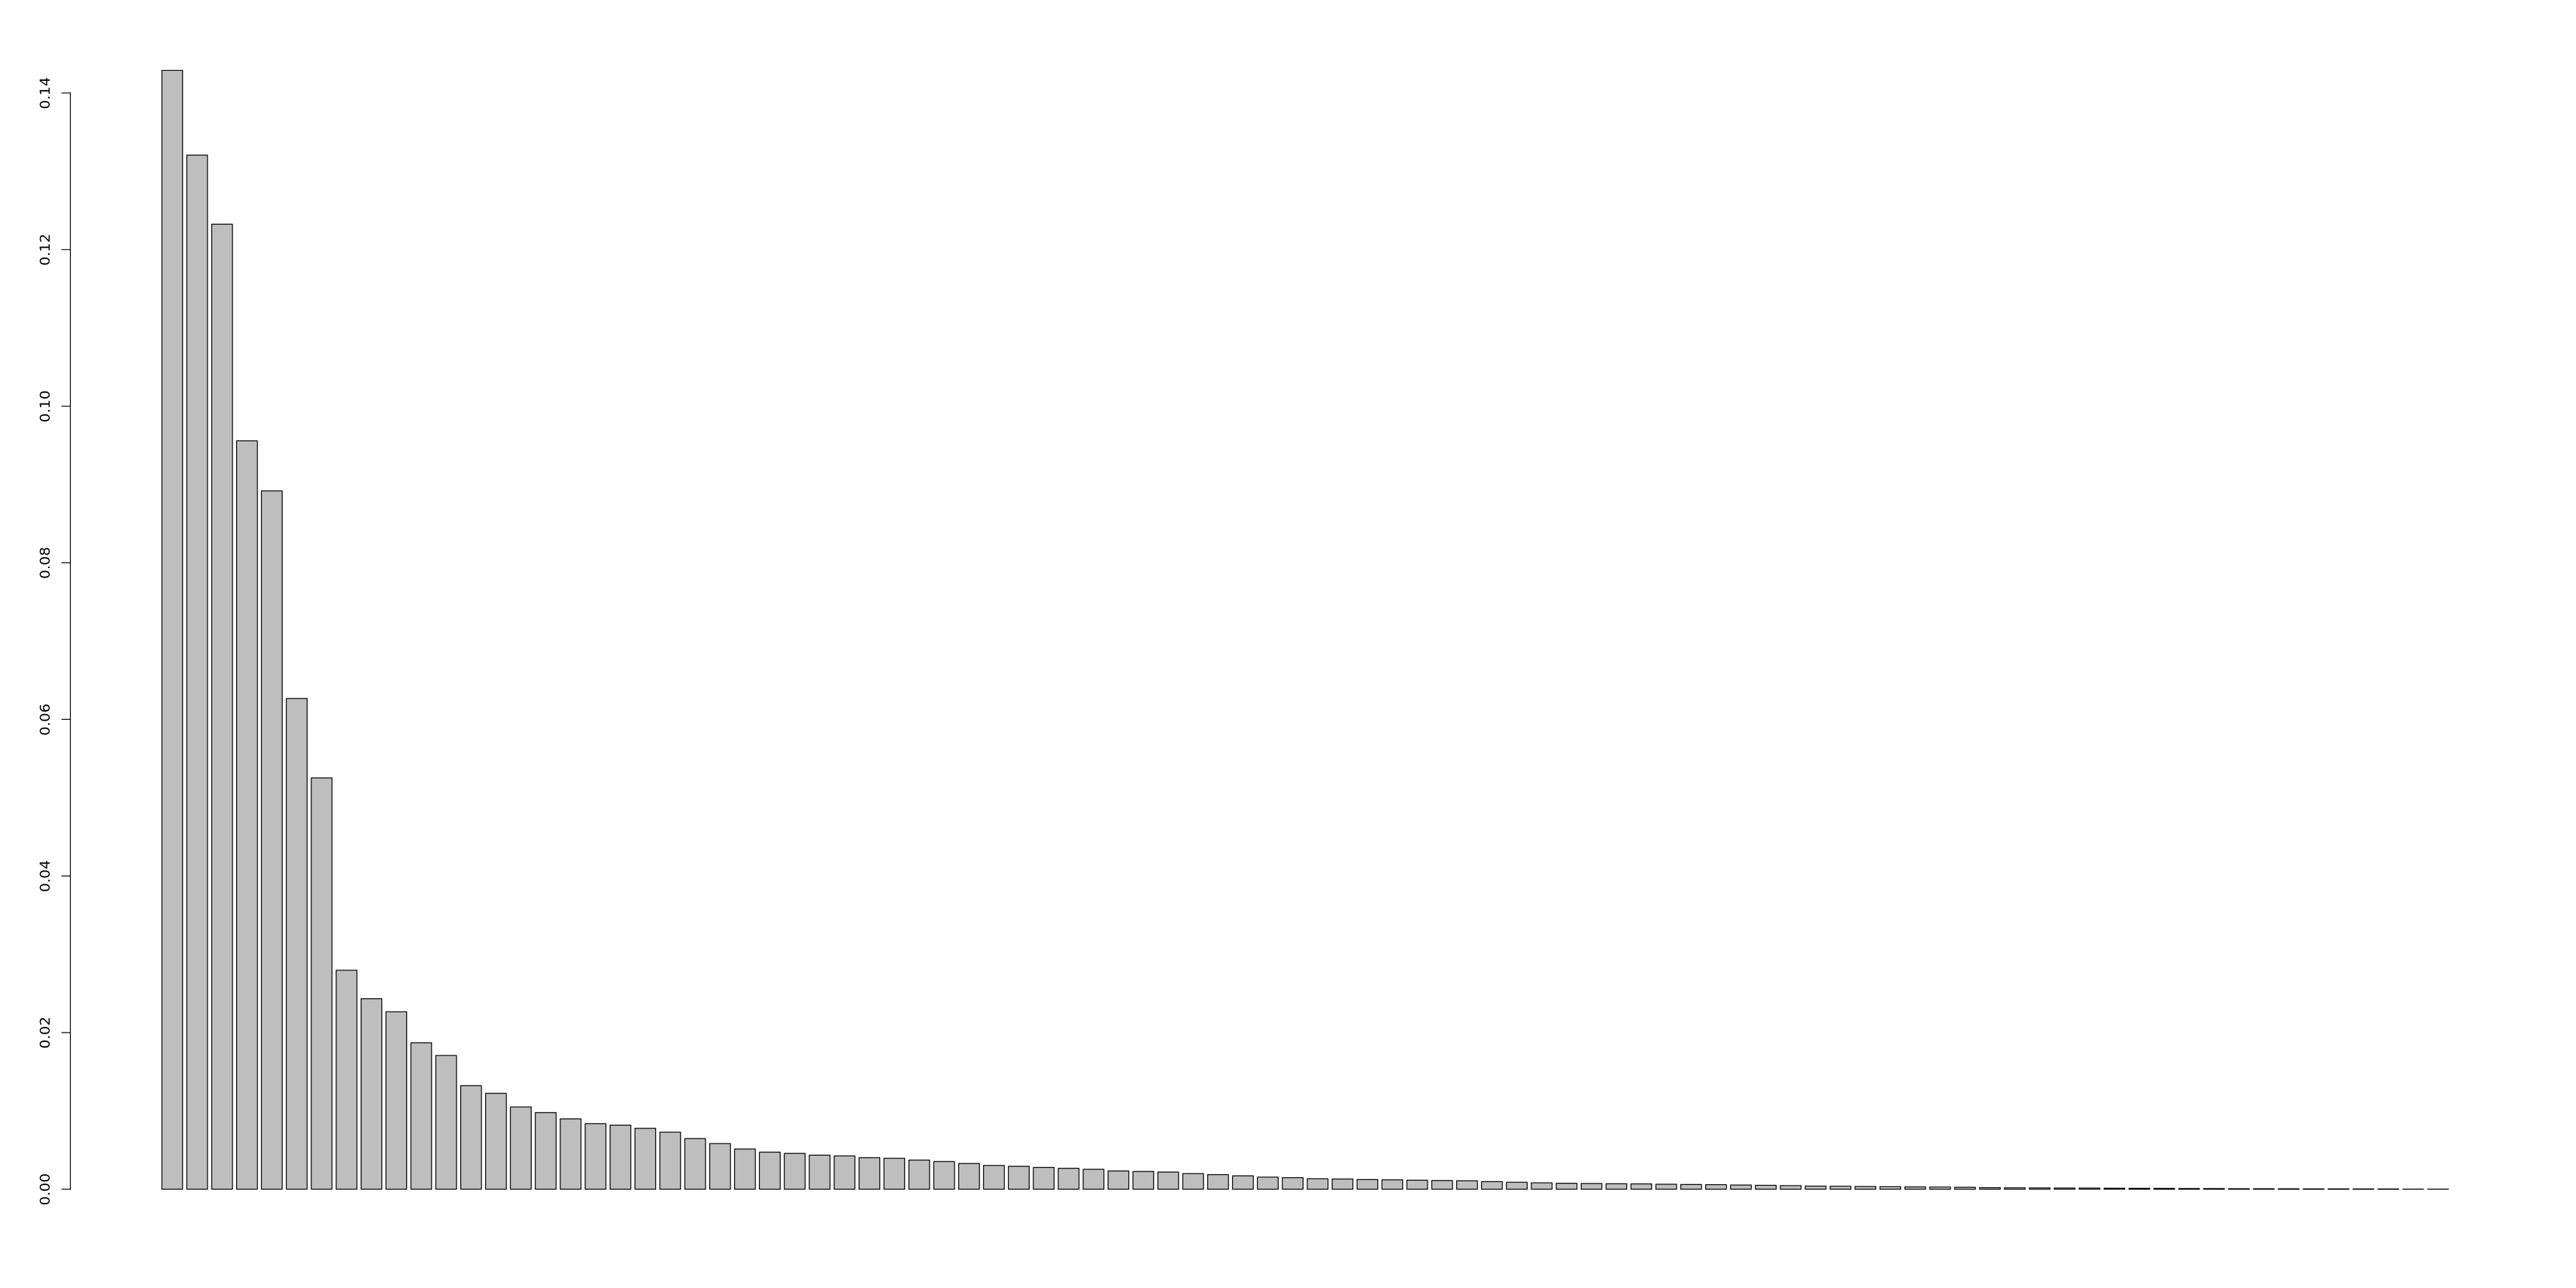

In [32]:
# Now plot a bar plot of relative eigenvalues. This is the percentage variance explained by each axis
barplot(as.vector(PCA$CA$eig)/sum(PCA$CA$eig)) 
# How much of the variance in our dataset is explained by the first principal component?

pca plots

In [35]:
# Calculate the percent of variance explained by first two axes
sum((as.vector(PCA$CA$eig)/sum(PCA$CA$eig))[1:2]) 
# hmmm I do not like that the first two axes only explain 27% of variance
sum((as.vector(PCA$CA$eig)/sum(PCA$CA$eig))[1:3]) 

[1] 0.2749456

[1] 0.3981911

# Correspondence Analysis using vegan

# df=n-1 

# what does kmeans actually do?

#This number of clusters should be determined according to the context and goal of your analysis (so according to your expectations or hypotheses)
model <- kmeans(otu_norm, centers = 2)

#The output model$cluster specifies the group (i.e., 1 or 2) to which each sample belongs to.
print(model$cluster)

calculate dissimilarity between samples using PERMANOVA in vegan